# LinearSVC trained with Bag of Words (BoW) (RQ1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE

### Load the data

In [2]:
# Load the training data 
X_train = pd.read_csv("data/lemmatized/X_train.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_train = pd.read_csv("data/lemmatized/y_train.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the validation data 
X_val = pd.read_csv("data/lemmatized/X_val.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_val = pd.read_csv("data/lemmatized/y_val.csv", index_col=0).reset_index(drop=True)['Sentiment']

# Load the test data 
X_test = pd.read_csv("data/lemmatized/X_test.csv", index_col=0).reset_index(drop=True)['CleanTweet']
y_test = pd.read_csv("data/lemmatized/y_test.csv", index_col=0).reset_index(drop=True)['Sentiment']

### BoW hyperparameter tuning
Use grid search with cross-validation to find the best hyperparameters for CountVectorizer. 

The `GridSearchCV` function performs a grid search with 5-fold cross-validation to find the best hyperparameters. 

In [4]:
# Define the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data
X_train_bow = vectorizer.fit_transform(X_train)

# Transform the validation 
X_val_bow = vectorizer.transform(X_val)

In [5]:
# Apply SMOTE to the BoW features
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

In [7]:
# Define the parameter grid to search over
param_grid = {'C': [0.3, 0.4, 0.5, 0.6, 0.75, 1, 1.25, 1.5, 2],     
              'class_weight': [None, 'balanced']}

# Perform grid search with cross-validation
grid_search = GridSearchCV(LinearSVC(), param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator from the grid search
best_svc = grid_search.best_estimator_

# Predict labels for the validation set
y_val_pred = best_svc.predict(X_val_bow)

# Print the classification report
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1433
           1       0.70      0.76      0.73       721
           2       0.86      0.84      0.85      1642

    accuracy                           0.82      3796
   macro avg       0.80      0.81      0.80      3796
weighted avg       0.82      0.82      0.82      3796



In [8]:
# Print the best hyperparameters and the corresponding F1 score
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Best hyperparameters: {'C': 0.3, 'class_weight': None}
Best F1 score: 0.8020208649792877


### Merge Train and Validation set
After selecting the best hyperparameters using the validation set, the model will be trained on the entire training set which includes both the original training data and the validation data. Once the model is trained, it will be evaluated on the test set to assess its performance.

In [10]:
# Merge X values
X_train_val = pd.concat([X_train, X_val], axis=0)

# Merge y values
y_train_val = pd.concat([y_train, y_val], axis=0)

### Create a CountVectorizer object with both X_train and X_val data

In [11]:
# Create a CountVectorizer object 
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_bow = vectorizer.fit_transform(X_train_val)

# Transform the test data
X_test_bow = vectorizer.transform(X_test)

In [12]:
# Apply SMOTE to the BoW features
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_bow, y_train_val)

### Train LinearSVC with best hyperparameters

Accuracy score: 79.61%
Classification report:

Class	Precision	Recall		F1-score	Support
-------------------------------------------------------
0	0.83		0.79		0.81		1633
1	0.67		0.72		0.69		617
2	0.82		0.84		0.83		1546
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1633
           1       0.67      0.72      0.69       617
           2       0.82      0.84      0.83      1546

    accuracy                           0.80      3796
   macro avg       0.77      0.78      0.78      3796
weighted avg       0.80      0.80      0.80      3796



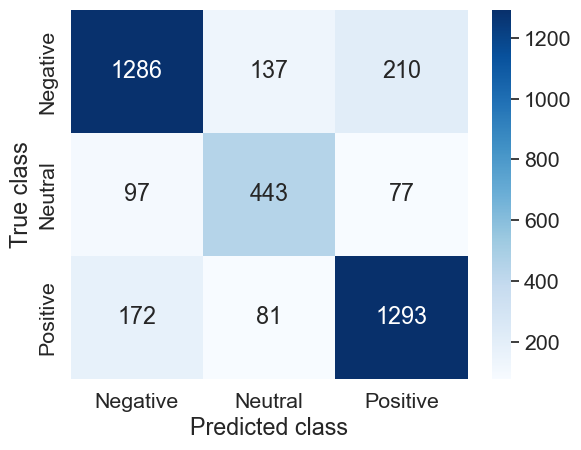

In [14]:
# Fit the model with best hyperparameters on the merged data
svc = LinearSVC(C=0.3)
svc.fit(X_train_resampled, y_train_resampled)

# Evaluate the performance of the pipeline on the test set
y_test_pred = svc.predict(X_test_bow)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy score: {:.2f}%".format(accuracy * 100))

# Calculate precision, recall, f1-score and support for each class
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Print the classification report
print("Classification report:\n")
print("Class\tPrecision\tRecall\t\tF1-score\tSupport")
print("-" * 55)
for i in range(len(precision)):
    print("{}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{}".format(i, precision[i], recall[i], f1[i], support[i]))
print("-" * 55)

# print the classification report
print(classification_report(y_test, y_test_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])

# Plot the confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)
    
    # Weighted Metrics
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Recall:", weighted_recall)
    print("Weighted Precision:", weighted_precision)
    print("Weighted F1 Score:", weighted_f1)


In [16]:
evaluate_model(svc, X_test_bow, y_test)

Confusion Matrix:
[[1286  137  210]
 [  97  443   77]
 [ 172   81 1293]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1633
           1       0.67      0.72      0.69       617
           2       0.82      0.84      0.83      1546

    accuracy                           0.80      3796
   macro avg       0.77      0.78      0.78      3796
weighted avg       0.80      0.80      0.80      3796

Weighted Recall: 0.7961011591148578
Weighted Precision: 0.7979963246110234
Weighted F1 Score: 0.7966672668573679


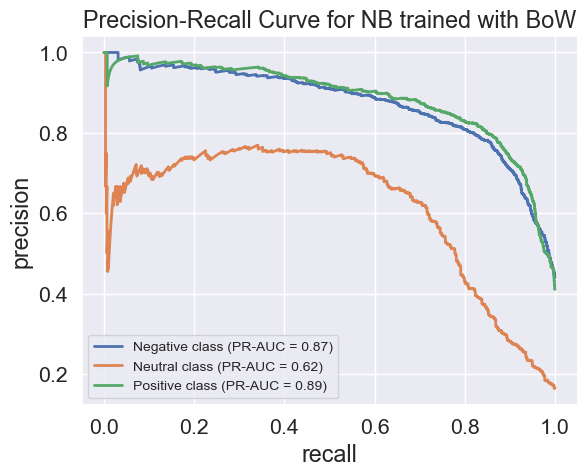

In [17]:
n_classes = 3

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# fit classifier and predict decision scores
decision_scores = svc.decision_function(X_test_bow)

# calculate precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()

class_names = [(0,'Negative'),(1,'Neutral'), (2,'Positive')]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], decision_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], decision_scores[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best",fontsize=10)
plt.title("Precision-Recall Curve for NB trained with BoW")
plt.show()

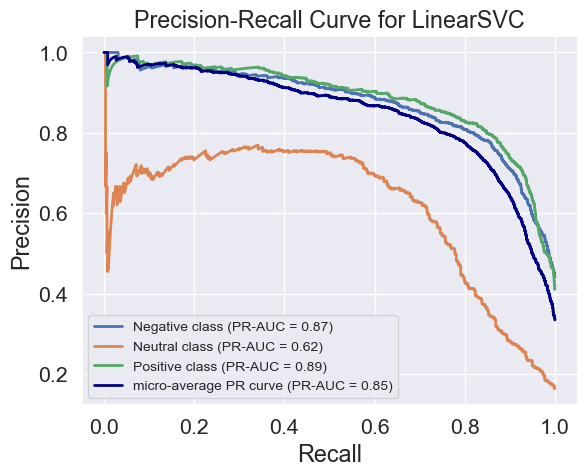

In [18]:
# Precision-Recall curve with Micro averaging for multiclass classification

# perform one-hot encoding on target variable
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# fit classifier and predict scores
y_score = svc.decision_function(X_test_bow)

# calculate precision and recall for each class using one-vs-all approach
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{} class (PR-AUC = {:.2f})'.format(class_names[i][1], average_precision[i]))
    
# calculate micro-averaged precision and recall
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# plot overall micro-averaged precision-recall curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='micro-average PR curve (PR-AUC = {0:0.2f})'
               ''.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best", fontsize=10)
plt.title('Precision-Recall Curve for LinearSVC')
plt.show()

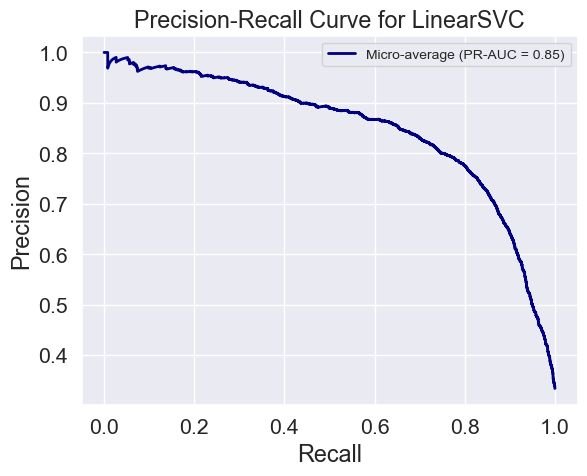

In [19]:
# Convert y_test to binary label matrix
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Fit classifier and predict probabilities
y_score = svc.decision_function(X_test_bow)

# Calculate precision and recall using micro averaging
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())

# Calculate average precision score using micro averaging
average_precision_micro = average_precision_score(y_test_bin, y_score, average='micro')

# Plot micro-average curve
plt.plot(recall_micro, precision_micro, color='navy', lw=2,
         label='Micro-average (PR-AUC = {0:0.2f})'.format(average_precision_micro))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best', fontsize=10)
plt.title('Precision-Recall Curve for LinearSVC')
plt.show()

#### Save Precision-Recall Curve

In [1]:
#np.save('Precision-Recall Curves/precision_micro_bow_SMOTE.npy', precision_micro)
#np.save('Precision-Recall Curves/recall_micro_bow_SMOTE.npy', recall_micro)

In [64]:
# load the array from file
#precision_micro_bow = np.load('Precision-Recall Curves/precision_micro_bow_SMOTE.npy')
#recall_micro_bow = np.load('Precision-Recall Curves/recall_micro_bow_SMOTE.npy')